In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, MultiPoint
import alphashape
import numpy as np
from shapely.ops import unary_union

import osmnx as ox
import momepy
from pyproj import Proj, Geod
import ast
from torch_geometric.data import Data
import network_io as nio
import pandas as pd

path_polygon = '../../../data/paris_inside_bvd_per/referentiel-comptages-edit.shp'
path_network = '../../../data/pop_1pm/paris_1pm_network.xml.gz'


# Abstract

The goal of this notebook is to generate random subgraphs. 

1. Load the network
2. Generate some random subgraphs
3. Visualize the network and the random subgraphs

In [2]:
df = nio.parse_network_xml_gz(path_network)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))
gdf_4326 = gdf.set_crs(epsg=2154).to_crs(epsg=4326)
districts = gpd.read_file("../../../data/visualisation/districts_paris.geojson")

# Parse nodes and edges
nodes_dict = nio.parse_nodes(path_network)
df_edges = nio.parse_edges(path_network, nodes_dict)

# Convert to GeoDataFrame and reproject
gdf_edges = gpd.GeoDataFrame(df_edges, geometry='geometry', crs='EPSG:2154')
gdf_edges_4326 = gdf_edges.to_crs(epsg=4326)

# Spatial join to find districts overlapping with each edge
gdf_edges_with_districts = gpd.sjoin(gdf_edges_4326, districts, how='left', op='intersects')

# Group by edge and aggregate the district names
gdf_edges_with_districts = gdf_edges_with_districts.groupby('id').agg({
    'from': 'first',
    'to': 'first',
    'length': 'first',
    'freespeed': 'first',
    'capacity': 'first',
    'permlanes': 'first',
    'oneway': 'first',
    'modes': 'first',
    'geometry': 'first',
    'c_ar': lambda x: list(x.dropna())
}).reset_index()

# Rename the aggregated column to 'district'
gdf_edges_with_districts.rename(columns={'c_ar': 'district'}, inplace=True)

# Display the resulting GeoDataFrame
gdf_edges_with_districts.head()

/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/pandas/core/reshape/merge.py:1203: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


,id,from,to,length,freespeed,capacity,permlanes,oneway,modes,geometry,district
0,100315,24972409,24972408,16.18125678991161,8.333333333333334,480.0,1.0,1,"bus,car,car_passenger","LINESTRING (2.33869 48.85181, 2.33847 48.85181)",[6.0]
1,100316,5904976363,24983651,14.860209130036054,8.333333333333334,480.0,1.0,1,"bus,car,car_passenger,pt","LINESTRING (2.33874 48.85242, 2.33872 48.85229)",[6.0]
2,100317,24983651,5904976363,14.860209130036054,8.333333333333334,960.0,2.0,1,"bus,car,car_passenger,pt","LINESTRING (2.33872 48.85229, 2.33874 48.85242)",[6.0]
3,100321,664205947,24972376,22.264539971200314,8.333333333333334,960.0,2.0,1,"car,car_passenger","LINESTRING (2.33994 48.85200, 2.33986 48.85181)",[6.0]
4,100324,24972376,24972375,64.85327605625626,8.333333333333334,480.0,1.0,1,"bus,car,car_passenger","LINESTRING (2.33986 48.85181, 2.33909 48.85152)",[6.0]


In [31]:
polygon_road_network = gpd.read_file(path_polygon)
alpha_shape = alphashape.alphashape(polygon_road_network, 435)
coordinates = list(alpha_shape.exterior[0].coords)
polygon = Polygon(coordinates)

# Plot the original GeoDataFrame
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# polygon_road_network.plot(ax=ax, color='black')
# ax.set_title('Original GeoDataFrame')
# plt.show()

# Convert the Polygon to a GeoDataFrame
gdf_polygon = gpd.GeoDataFrame([1], geometry=[polygon], crs="EPSG:4326")

# Plot the GeoDataFrame
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# gdf_polygon.plot(ax=ax, color=None, edgecolor='black')
# ax.set_title('Alpha Shape Polygon')
# plt.show()

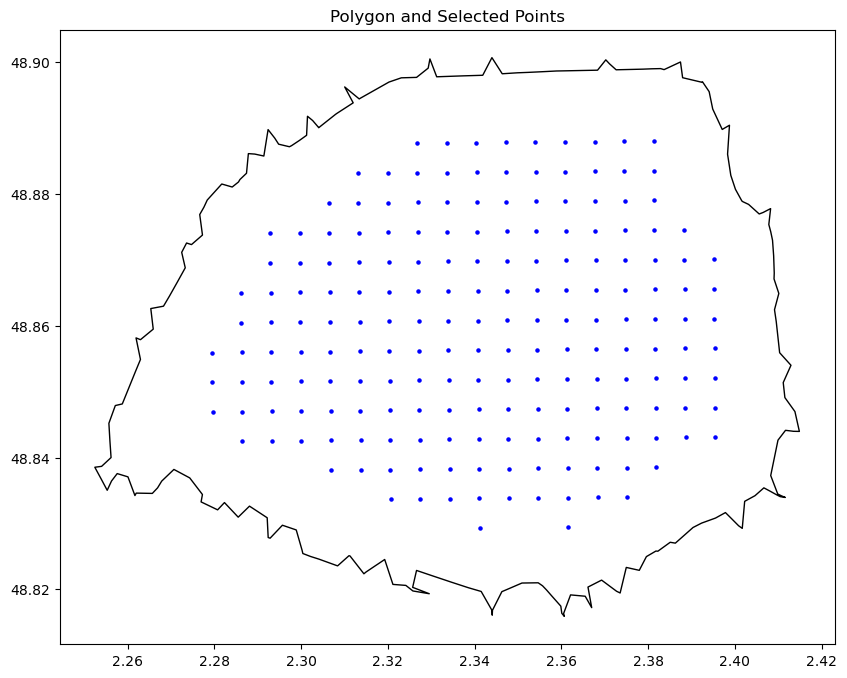

In [82]:
# Reproject the GeoDataFrame to a projected CRS (UTM zone 31N for Paris)
gdf_polygon_proj = gdf_polygon.to_crs(epsg=32631)

# Buffer the polygon inward by 1 km
buffered_polygon_proj = gdf_polygon_proj.buffer(-1000)

# Reproject the buffered polygon back to the original CRS
buffered_polygon = buffered_polygon_proj.to_crs(epsg=4326)

# Function to create a grid of points
def create_grid(polygon, spacing):
    minx, miny, maxx, maxy = polygon.bounds
    x_coords = np.arange(minx, maxx, spacing)
    y_coords = np.arange(miny, maxy, spacing)
    grid_points = [Point(x, y) for x in x_coords for y in y_coords]
    return grid_points

# Create a grid of points with a spacing of 500m
grid_spacing = 500  # in meters
grid_points = create_grid(gdf_polygon_proj.geometry[0], grid_spacing)

# Further filter points that are inside the buffered polygon
points_inside_buffered_polygon = [point for point in grid_points if buffered_polygon_proj.iloc[0].contains(point)]

# Convert the selected points to a GeoDataFrame in the projected CRS
gdf_points_proj = gpd.GeoDataFrame(geometry=points_inside_buffered_polygon, crs=gdf_polygon_proj.crs)

# Reproject the points back to EPSG:4326
gdf_points_4326 = gdf_points_proj.to_crs(epsg=4326)
gdf_polygon_4326 = gdf_polygon.to_crs(epsg=4326)

# Plot the polygon and the selected points
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_polygon_4326.plot(ax=ax, color='none', edgecolor='black')
gdf_points_4326.plot(ax=ax, color='blue', markersize=5)
ax.set_title('Polygon and Selected Points')
plt.show()